# Recomendação de Jogos da Steam
## Projeto da disciplina **SCC0284 - Sistemas de Recomendação**

* Lucas Ciziks - 12559472 - luciziks@usp.br

* Pedro Maçonetto - 12675419 - pedromaconetto@usp.br

In [2]:
# Bibliotecas a serem utilizadas no trabalho
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from caserec.recommenders.item_recommendation.item_attribute_knn import ItemAttributeKNN
import six
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import optimizers, serializers
from tqdm import tqdm

## Bases de Dados
Serão utilizadas duas bases de dados encontradas no Kaggle. A base de dados principal reúne as críticas/*reviews* de usuários de todo o mundo para alguns jogos da plataforma, com 8GB de dados. Em conjunto, utilizaremos uma base complementar contendo os metadados dos jogos para auxílio nos algoritmos de recomendação implementados.

As bases completas podem ser acessadas em:

* [Steam Reviews](https://www.kaggle.com/datasets/andrewmvd/steam-reviews): Avaliações reais de jogos na plataforma
Steam em 2021; 
* [Steam Metadata](https://www.kaggle.com/datasets/nikdavis/steam-store-games): Informações e metadados sobre os jogos
disponíveis na plataforma Steam. 

### Amostragem

Como a base de *reviews* é extremamente grande, com mais de 8GB de tamanho, tomaremos uma amostra com **100000 usuários** para aplicarmos e testarmos os métodos em um tempo hábil de processamento.

In [3]:
# Importando arquivo de Reviews da Steam
# df = pd.read_csv('steam_reviews.csv')

# Separando os valores únicos de todos os usuários presentes
# steam_id = df['author.steamid'].unique()

# Escolhemos aleatoriamente 100000 desses usuários
# random_users = np.random.choice(steam_id, 100000)

# Criamos um DataFrame separado somente com estes usuários e suas informações
# data_reduzido = df[df['author.steamid'].isin(random_users)]

# Transformamos por fim este dataframe em um arquivo .csv para facilitar a manipulação dos dados ao longo do tempo
# data_reduzido.to_csv('reviews_reduzido.csv')

### Tratamento de Dados

Utilizando a base de dados reduzida, armazenada no arquivo *reviews_reduzido.csv*, a próxima etapa é limpar e adequar os dados para os recomendadores.

In [4]:
# Reviews Reduzido dos jogos
review = pd.read_csv('reviews_reduzido.csv')
review.head()

,Unnamed: 0.1,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,1917,1917,292030,The Witcher 3: Wild Hunt,84817041,polish,cos malo kontentu,1610838136,1610838136,True,...,True,False,False,76561199069719082,16,1,3442.0,1777.0,2903.0,1.611356e+09
1,2212,2212,292030,The Witcher 3: Wild Hunt,84770465,english,Better than some games.,1610776476,1610776476,True,...,True,False,False,76561198134193481,10,1,19397.0,1030.0,18917.0,1.611383e+09
2,2292,2292,292030,The Witcher 3: Wild Hunt,84753053,english,still one of my favorite games love the story ...,1610749166,1610749166,True,...,True,False,False,76561198076025535,106,6,364.0,55.0,308.0,1.610775e+09
3,2923,2923,292030,The Witcher 3: Wild Hunt,84646036,koreana,재미있음 너무 퀘스트가 많아서 할게 많아보이지만 안해도되는거 같음 메인퀘를 중심으로...,1610589095,1610589095,True,...,True,False,False,76561198043684666,10,1,2561.0,1836.0,1060.0,1.610974e+09
4,3774,3774,292030,The Witcher 3: Wild Hunt,84500650,turkish,.,1610382839,1610382839,True,...,True,False,False,76561198954233218,26,1,2611.0,923.0,2141.0,1.611362e+09


In [5]:
# Metadados dos Jogos
metadados = pd.read_csv('steam_metadados.csv')
metadados.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [6]:
# Removendo colunas que não serão utilizadas, e renomeando as que serão
review = review.drop(['Unnamed: 0.1', 'Unnamed: 0', 'timestamp_created', 'received_for_free', 'written_during_early_access', 'votes_helpful', 'votes_funny', 'weighted_vote_score', 'timestamp_updated'], axis=1)
review = review.rename(columns = {'app_id': 'itemId', 'app_name': 'itemName', 'review_id': 'reviewId',
       'comment_count': 'commentCount', 'steam_purchase': 'steamPurchase',
       'author.steamid': 'userId', 'author.num_games_owned': 'userGames', 'author.num_reviews': 'userReviews',
       'author.playtime_forever': 'userPlaytimeForever', 'author.playtime_last_two_weeks': 'userPlaytimeLastTwoWeeks',
       'author.playtime_at_review': 'userPlaytimeAtReview', 'author.last_played': 'userLastPlayed'})
metadados.rename(columns = {'appid': 'itemId', 'name': 'itemName'}, inplace= True)

In [7]:
# Como utilizamos uma amostragem da base de dados original, faremos um cruzamento de dados 
# entre os jogos da amostra e os jogos disponíveis nos metadados
commonItems = list(set(metadados.itemName.unique())&set(review.itemName))
review = review.loc[review['itemName'].isin(commonItems)]
metadados = metadados.loc[metadados['itemName'].isin(commonItems)]

In [8]:
# Mapeamento de itens e usuários
itemId = {item: idx for idx, item in enumerate(commonItems)}
userId = {user: idx for idx, user in enumerate(review['userId'])}

metadados['itemId'] = metadados['itemName'].map(itemId).dropna()
review['itemId'] = review['itemName'].map(itemId).dropna()
review['userId'] = review['userId'].map(userId).dropna()

# Binarizando a feedback dado pelo usuário (recomendado ou não-recomendado)
review['rating'] = review['recommended'].apply(lambda review: 1 if review else 0)

# Separando os gêneros dos itens do arquivo de metadados
metadados = metadados.drop('genres', axis=1).join(metadados.genres.str.split(';', expand=True)
             .stack().reset_index(drop=True, level=1).rename('genre'))
metadados.dropna(inplace=True)

In [9]:
# Bases após o tratamento
review.head()

,itemId,itemName,reviewId,language,review,recommended,commentCount,steamPurchase,userId,userGames,userReviews,userPlaytimeForever,userPlaytimeLastTwoWeeks,userPlaytimeAtReview,userLastPlayed,rating
379,101,Half-Life,84840205,turkish,D-dostum torent kullanma ve al,True,0,True,0,26,2,79.0,0.0,79.0,1.592832e+09,1
380,101,Half-Life,84803254,english,its pretty good.,True,0,True,3649,11,5,564.0,9.0,555.0,1.610943e+09,1
381,101,Half-Life,83553107,german,Immer noch ein absolut geniales Spiel. Die Ste...,True,0,True,2,15,1,329.0,0.0,329.0,1.608773e+09,1
382,101,Half-Life,83546336,turkish,bu oyunu unlost izledikten sonra alanlar :D,True,0,True,5658,6,4,650.0,69.0,319.0,1.610887e+09,1
383,101,Half-Life,78617643,english,fun,True,0,True,10961,56,19,915.0,0.0,297.0,1.605903e+09,1


In [10]:
metadados.head()

,itemId,itemName,release_date,english,developer,publisher,platforms,required_age,categories,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,genre
6,101,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,FPS;Classic;Action,0,27755,1100,1300,83,5000000-10000000,7.19,Action
10,208,Counter-Strike: Source,2004-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;FPS;Multiplayer,147,76640,3497,6842,400,10000000-20000000,7.19,Action
18,114,Half-Life 2: Episode Two,2007-10-10,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,FPS;Action;Sci-fi,22,13902,696,354,301,5000000-10000000,5.79,Action
23,210,Portal 2,2011-04-18,1,Valve,Valve,windows;mac;linux,0,Single-player;Co-op;Steam Achievements;Full co...,Puzzle;Co-op;First-Person,51,138220,1891,1102,520,10000000-20000000,7.19,Action
23,210,Portal 2,2011-04-18,1,Valve,Valve,windows;mac;linux,0,Single-player;Co-op;Steam Achievements;Full co...,Puzzle;Co-op;First-Person,51,138220,1891,1102,520,10000000-20000000,7.19,Adventure


## Recomendadores

### Hold-Out

Para que o sistema não apresente resultados enviezados, separamos a base em um conjunto de treinamento e um conjunto de teste. Assim, é possível treinar o modelo com o recomendador e avaliá-lo através do teste.

In [11]:
train, test = train_test_split(review, test_size=.2, random_state=2)

### Avaliação

Abaixo estão implementadas algumas funções de métricas para realizarmos a avaliação offline dos recomendadores.

In [12]:
# Calcula o RMSE para um usuário
def rmse_user(preds, ratings):
    if len(preds) != len(ratings):
        return -1

    sum = 0
    for i in range(len(preds)):
        sum += pow(preds[i] - ratings[i], 2)
        
    return np.sqrt(sum/len(preds))

In [13]:
# Calcula a métrica Average Precision (AP)
def average_precision(recommended_items, relevant_items, limiar):
    index = score = hit = 0

    while index < len(recommended_items) and hit < limiar:
        if recommended_items[index] in relevant_items:
            hit += 1
            score += hit / (index + 1)
        index += 1

    return score / hit if hit > 0 else 0

# Calcula o métrica Mean Average Precision (MAP)
def MAP(result, ground_truth, limiar=np.inf):
    commom_user = list(set(result['userId']) & set(ground_truth['userId']))
    score = 0

    for user in commom_user:
        recommended_items = result.loc[result.userId == user, 'itemId'].tolist()
        user_relevant_items = ground_truth.loc[ground_truth.userId == user, 'itemId'].tolist()
        score += average_precision(recommended_items, user_relevant_items, limiar)

    return score / len(commom_user)

In [14]:
# Calcula ILS - métrica de diversidade
def ILS_diversity(recommended_games, similarity_games):
    ils = 0
    
    for game1 in recommended_games:
        for game2 in recommended_games:
            if game1 != game2:
                first = game1 if game1 < game2 else game2
                second = game1 if game1 > game2 else game2
                similarity = similarity_games.loc[(similarity_games["Game 1"] == first) & (similarity_games["Game 2"] == second), "Similarity"].values[0]
                ils += similarity
    
    return ils / 2

# Calcula a métrica de diversidade para todos os usuários
def mean_ILS(recommendations, similarity_games):
    all_users = recommendations['userId'].unique().tolist()

    total_ils = 0
    for user in all_users:
        recommended_items = recommendations.loc[(recommendations.userId == user)].sort_values(by="score", ascending=False)[:10]["itemId"].tolist()
        total_ils += ILS_diversity(recommended_items, similarity_games)
    
    return total_ils / len(all_users)

## Pointwise

### Optimized SVD (Filtragem Colaborativa Baseada em Modelo)


In [15]:
# Treino do modelo SVD Otimizado
def train_svdopt(train, n_factors, lr=0.05, reg=0.02, miter=10):
    global_mean = train['rating'].mean()
    n_users = review['userId'].max()+1
    n_items = review['itemId'].max()+1
    bu = np.zeros(n_users)
    bi = np.zeros(n_items)
    p = np.random.normal(0.1, 0.1, (n_users, n_factors))
    q = np.random.normal(0.1, 0.1, (n_items, n_factors))
    error = []

    for t in range(miter):
        sq_error = 0
        for index, row in train.iterrows():
            u = row['userId']
            i = row['itemId']
            r_ui = row['rating']
            pred = global_mean + bu[u] + bi[i] + np.dot(p[u], q[i])
            e_ui = r_ui - pred
            sq_error = sq_error + pow(e_ui, 2)
            bu[u] = bu[u] + lr * e_ui
            bi[i] = bi[i] + lr * e_ui

            for f in range(n_factors):
                temp_uf = p[u][f]
                p[u][f] = p[u][f] + lr * (e_ui * q[i][f] - reg * p[u][f])
                q[i][f] = q[i][f] + lr * (e_ui * temp_uf - reg * q[i][f])
        
        error.append(sqrt(sq_error/len(train)))

    return global_mean, bu, bi, p, q, error

In [16]:
# Coletando parâmetros calculados
n_factors = 5
gl, bu, bi, p, q, error = train_svdopt(train, n_factors, miter=30)

In [17]:
# Aplicando modelo no conjunto de teste e recuperando predições
rmse_users = []
all_users = test["userId"].unique().tolist()

for user in all_users:
    items = test.loc[(test.userId == user), "itemId"].tolist()
    predictions_user = []
    real_ratings = []
    
    # Calculando predições e notas reais
    for item in items:
        real_ratings.append(test.loc[(test.userId == user) & (test.itemId == item), 'rating'].values[0])
        predictions_user.append(gl + bu[user] + bi[item] + np.dot(p[user], q[item]))
    
    # Calculando RMSE do usuário
    rmse_users.append(rmse_user(predictions_user, real_ratings))

In [18]:
# RMSE
mean_rmse = np.sum(rmse_users) / len(rmse_users)
print(mean_rmse)

0.2135860583355554


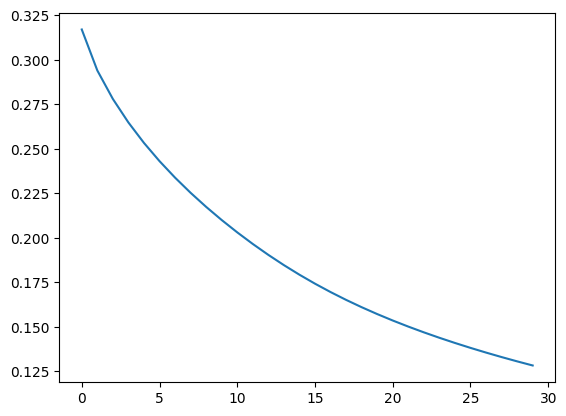

In [19]:
plt.plot(error)
plt.show()

In [20]:
users = []
items = []
score = []

for user in test.userId.unique():
    for item in test.itemId.unique():
        users.append(user)
        items.append(item)
        score.append(gl + bu[user] + bi[item] + np.dot(p[user], q[item]))

In [21]:
# Calculando MAP do SVD Otimizado
result_svd = pd.DataFrame({
    'userId':users, 
    'itemId':items, 
    'score':score
    })

map_svd = pd.Series([
    MAP(result_svd, test, 1), 
    MAP(result_svd, test, 3), 
    MAP(result_svd, test, 5), 
    MAP(result_svd, test, 10),
    ])

map_svd

0    0.065371
1    0.062340
2    0.062200
3    0.062188
dtype: float64

### Filtragem Baseada em Conteúdo

Como exemplo de algoritmo para Filtragem Baseada em Conteúdo, utilizaremos o **ItemAttributeKNN**, já implementado pela biblioteca CaseRecommender. Primeiramente, testaremos com o cálculo de similaridade da própria biblioteca.

In [22]:
# Gerando arquivo com metadados
metadados[['itemId', 'genre']].to_csv('meta_genres.dat', index=False, sep='\t', header=False)
train[['userId', 'itemId', 'rating']].to_csv('train.dat', index=False, header=False, sep='\t')
test[['userId', 'itemId', 'rating']].to_csv('test.dat', index=False, header=False, sep='\t')

In [23]:
# Utilizando Algoritmo ItemAttributeKNN com similaridade calculada internamente
ItemAttributeKNN('train.dat', 'test.dat', output_file='result_IAKNN.dat', metadata_file='meta_genres.dat', as_similar_first=True).compute()

[Case Recommender: Item Recommendation > Item Attribute KNN Algorithm]

train data:: 7031 users and 215 items (10596 interactions) | sparsity:: 99.30%
test data:: 2270 users and 182 items (2650 interactions) | sparsity:: 99.36%

training_time:: 0.033941 sec
>> metadata:: 216 items and 19 metadata (557 interactions) | sparsity:: 86.43%
prediction_time:: 10.944772 sec


Eval:: PREC@1: 0.004846 PREC@3: 0.004846 PREC@5: 0.004405 PREC@10: 0.004846 RECALL@1: 0.003304 RECALL@3: 0.010808 RECALL@5: 0.016021 RECALL@10: 0.037203 MAP@1: 0.004846 MAP@3: 0.008737 MAP@5: 0.010301 MAP@10: 0.013817 NDCG@1: 0.004846 NDCG@3: 0.012424 NDCG@5: 0.015563 NDCG@10: 0.024538 


In [24]:
result_IAKNN = pd.read_csv('result_IAKNN.dat', sep='\t', names=['userId', 'itemId', 'score'])
result_IAKNN.head()

,userId,itemId,score
0,0,12,1.0
1,0,13,1.0
2,0,31,1.0
3,0,58,1.0
4,0,65,1.0


In [25]:
# Calculando MAP da Filtragem Baseada em Conteúdo
map_IAKNN = pd.Series([
    MAP(result_IAKNN, test, 1),
    MAP(result_IAKNN, test, 3), 
    MAP(result_IAKNN, test, 5), 
    MAP(result_IAKNN, test, 10),
    ])

map_IAKNN

0    0.029418
1    0.029394
2    0.029394
3    0.029394
dtype: float64

Aplicando a similaridade de cosseno com os atributos **Categoria** e **Genêro** do jogo, salvaremos o resultado em um arquivo de similaridade. Esse arquivo será passado como argumento para a biblioteca CaseRecommender. 

In [26]:
# Separando categorias e gêneros de cada jogo
dummies_categorie = pd.get_dummies(metadados[['itemId', 'categories']], columns=['categories'])
dummies_genre = pd.get_dummies(metadados[['itemId', 'genre']], columns=['genre'])
all_items = metadados.itemId.unique()

# Calculando a similaridade por cosseno utilizando a categoria e gênero do jogo
similarity = []
for item1 in all_items:
    for item2 in all_items:
        if item1 < item2:
            category_sim = cosine_similarity([dummies_categorie.loc[dummies_categorie.itemId == item1].sum()[1:].values], [dummies_categorie.loc[dummies_categorie.itemId == item2].sum()[1:].values])[0]
            genre_sim = cosine_similarity([dummies_genre.loc[dummies_genre.itemId == item1].sum()[1:].values], [dummies_genre.loc[dummies_genre.itemId == item2].sum()[1:].values])[0]
            similarity.append([item1, item2, (category_sim + genre_sim)/ 2]) # média simples entre as duas similaridades

# Salvando similaridades no arquivo
with open('sim_games.dat', 'w') as arq_sim:
  for i in similarity:
    arq_sim.write(str(i[0]) + '\t' + str(i[1]) + '\t' + str(i[2][0]) + '\n')

In [27]:
# Utilizando Algoritmo ItemAttributeKNN com similaridade de cosseno calculada através do gênero + categoria
ItemAttributeKNN('train.dat', 'test.dat', output_file='recs_iaknn_cos.dat',
                 similarity_file='sim_games.dat', as_similar_first=True).compute()

[Case Recommender: Item Recommendation > Item Attribute KNN Algorithm]

train data:: 7031 users and 215 items (10596 interactions) | sparsity:: 99.30%
test data:: 2270 users and 182 items (2650 interactions) | sparsity:: 99.36%

training_time:: 0.115693 sec
prediction_time:: 9.728204 sec


Eval:: PREC@1: 0.003084 PREC@3: 0.003524 PREC@5: 0.003084 PREC@10: 0.003392 RECALL@1: 0.002093 RECALL@3: 0.007966 RECALL@5: 0.01149 RECALL@10: 0.025147 MAP@1: 0.003084 MAP@3: 0.005874 MAP@5: 0.006953 MAP@10: 0.009327 NDCG@1: 0.003084 NDCG@3: 0.008459 NDCG@5: 0.010699 NDCG@10: 0.016944 


In [28]:
# Lendo arquivo de similaridade
result_IAKNN_sim = pd.read_csv('recs_iaknn_cos.dat', sep='\t', names=['userId', 'itemId', 'score'])
result_IAKNN_sim.head()

,userId,itemId,score
0,0,12,0.5
1,0,13,0.5
2,0,31,0.5
3,0,58,0.5
4,0,65,0.5


In [29]:
# Calculando MAP
map_IAKNN_sim = pd.Series([
    MAP(result_IAKNN_sim, test, 1),
    MAP(result_IAKNN_sim, test, 3), 
    MAP(result_IAKNN_sim, test, 5), 
    MAP(result_IAKNN_sim, test, 10),
    ])
map_IAKNN_sim

0    0.019842
1    0.019842
2    0.019842
3    0.019842
dtype: float64

## Pairwise

Utilizando o algoritmo BPR como exemplo de Pairwise, testaremos sua implementação da biblioteca CaseRecommender com diferentes números de fatores: 5, 15 e 30.

### BPRMF - 5 Fatores

In [30]:
from caserec.recommenders.item_recommendation.bprmf import BprMF

# Algoritmo BPRMF com 5 fatores
BprMF('train.dat', 'test.dat', 'result_BPRMF_5.dat', factors=5).compute()

[Case Recommender: Item Recommendation > BPRMF]

train data:: 7031 users and 215 items (10596 interactions) | sparsity:: 99.30%
test data:: 2270 users and 182 items (2650 interactions) | sparsity:: 99.36%

training_time:: 8.012239 sec
prediction_time:: 0.953385 sec


Eval:: PREC@1: 0.043612 PREC@3: 0.03069 PREC@5: 0.024405 PREC@10: 0.021322 RECALL@1: 0.034372 RECALL@3: 0.072104 RECALL@5: 0.096259 RECALL@10: 0.166733 MAP@1: 0.043612 MAP@3: 0.062812 MAP@5: 0.068168 MAP@10: 0.077025 NDCG@1: 0.043612 NDCG@3: 0.081345 NDCG@5: 0.092474 NDCG@10: 0.116689 


In [31]:
# Calculando MAP de BPRMF para 5 fatores
result_BPRMF_5 = pd.read_csv('result_BPRMF_5.dat', sep='\t', names=['userId', 'itemId', 'score'])

map_BPRMF_5 = pd.Series([
    MAP(result_BPRMF_5, test, 1),
    MAP(result_BPRMF_5, test, 3), 
    MAP(result_BPRMF_5, test, 5), 
    MAP(result_BPRMF_5, test, 10),
    ])
    
map_BPRMF_5

0    0.168172
1    0.163876
2    0.163872
3    0.163868
dtype: float64

### BPRMF - 15 Fatores

In [32]:
# Algoritmo BPRMF com 15 fatores
BprMF('train.dat', 'test.dat', 'result_BPRMF_15.dat', factors=15).compute()

[Case Recommender: Item Recommendation > BPRMF]

train data:: 7031 users and 215 items (10596 interactions) | sparsity:: 99.30%
test data:: 2270 users and 182 items (2650 interactions) | sparsity:: 99.36%

training_time:: 7.731400 sec
prediction_time:: 1.050777 sec


Eval:: PREC@1: 0.039648 PREC@3: 0.029075 PREC@5: 0.026256 PREC@10: 0.020881 RECALL@1: 0.031751 RECALL@3: 0.072258 RECALL@5: 0.105973 RECALL@10: 0.165452 MAP@1: 0.039648 MAP@3: 0.060646 MAP@5: 0.069086 MAP@10: 0.076893 NDCG@1: 0.039648 NDCG@3: 0.081094 NDCG@5: 0.098403 NDCG@10: 0.120097 


In [33]:
# Calculando MAP de BPRMF para 15 fatores
result_BPRMF_15 = pd.read_csv('result_BPRMF_15.dat', sep='\t', names=['userId', 'itemId', 'score'])

map_BPRMF_15 = pd.Series([
    MAP(result_BPRMF_15, test, 1),
    MAP(result_BPRMF_15, test, 3), 
    MAP(result_BPRMF_15, test, 5), 
    MAP(result_BPRMF_15, test, 10),
    ])
    
map_BPRMF_15

0    0.166845
1    0.163621
2    0.163588
3    0.163588
dtype: float64

### BPRMF - 30 Fatores

In [34]:
# Algoritmo BPRMF com 30 fatores
BprMF('train.dat', 'test.dat', 'result_BPRMF_30.dat', factors=30).compute()

[Case Recommender: Item Recommendation > BPRMF]

train data:: 7031 users and 215 items (10596 interactions) | sparsity:: 99.30%
test data:: 2270 users and 182 items (2650 interactions) | sparsity:: 99.36%

training_time:: 7.854748 sec
prediction_time:: 1.033998 sec


Eval:: PREC@1: 0.040088 PREC@3: 0.032893 PREC@5: 0.027048 PREC@10: 0.021013 RECALL@1: 0.031347 RECALL@3: 0.079339 RECALL@5: 0.105661 RECALL@10: 0.165385 MAP@1: 0.040088 MAP@3: 0.062812 MAP@5: 0.069833 MAP@10: 0.077489 NDCG@1: 0.040088 NDCG@3: 0.084749 NDCG@5: 0.099474 NDCG@10: 0.119895 


In [35]:
# Calculando MAP de BPRMF para 30 fatores
result_BPRMF_30 = pd.read_csv('result_BPRMF_30.dat', sep='\t', names=['userId', 'itemId', 'score'])

map_BPRMF_30 = pd.Series([
    MAP(result_BPRMF_30, test, 1),
    MAP(result_BPRMF_30, test, 3), 
    MAP(result_BPRMF_30, test, 5), 
    MAP(result_BPRMF_30, test, 10),
    ])

map_BPRMF_30

0    0.168071
1    0.164852
2    0.164856
3    0.164856
dtype: float64

## Listwise

### ListNet

Implementação do algoritmo ListNet da família Listwise, teorizado e desenvolvido em "Learning to Rank: From Pairwise Approach to Listwise Approach." por Zhe Cao, Tao Qin, Tie-Yan Liu, Ming-Feng Tsai e Hang Li. A implementação foi baseada no código-fonte de https://github.com/shiba24/learning2rank.

In [36]:
def acc(train_acc, test_acc, savename='result_acc.pdf'):
    ep = np.arange(len(train_acc)) + 1

    plt.plot(ep, train_acc, color="blue", linewidth=1, linestyle="-", label="Train")
    plt.plot(ep, test_acc, color="red",  linewidth=1, linestyle="-", label="Test")
    plt.title("Accuracy")
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.legend(loc='lower right')
    plt.savefig(savename)
        
def loss(train_loss, test_loss, savename='result_loss.pdf'):
    ep = np.arange(len(train_loss)) + 1

    plt.plot(ep, train_loss, color="blue", linewidth=1, linestyle="-", label="Train")
    plt.plot(ep, test_loss, color="red",  linewidth=1, linestyle="-", label="Test")
    plt.title("Loss")
    plt.xlabel("iteration")
    plt.ylabel("loss")

    plt.legend(loc='upper right')
    plt.savefig(savename)

In [37]:
class NN(object):

    def loadModel(self, modelName):
        print('Load model')
        serializers.load_hdf5(modelName, self.model)
        print('Load optimizer state')
        serializers.load_hdf5(modelName[:-5] + 'state', self.optimizer)


    def initializeModel(self, Model, train_X, n_units1, n_units2, optimizerAlgorithm):
        print("prepare initialized model!")
        self.model = Model(len(train_X[0]), n_units1, n_units2, 1)
        self.initializeOptimizer(optimizerAlgorithm)

    def initializeOptimizer(self, optimizerAlgorithm):
        if optimizerAlgorithm == "Adam":
            self.optimizer = optimizers.Adam()
        elif optimizerAlgorithm == "AdaGrad":
            self.optimizer = optimizers.AdaGrad()
        elif optimizerAlgorithm == "SGD":
            self.optimizer = optimizers.MomentumSGD()
        else:
            raise ValueError('could not find %s in optimizers {"Adam", "AdaGrad", "SGD"}' % (optimizerAlgorithm))
        self.optimizer.setup(self.model)

    def saveModels(self, savemodelName):
        print('save the model')
        serializers.save_hdf5(savemodelName, self.model) 
        print('save the optimizer')
        serializers.save_hdf5(savemodelName[:-5]+ 'state', self.optimizer)  

    def splitData(self, fit_X, fit_y, tv_ratio):
        print('load dataset')
        perm = np.random.permutation(len(fit_X))
        N_train = int(np.floor(len(fit_X) * tv_ratio))
        train_X, validate_X = np.split(fit_X[perm].astype(np.float32),   [N_train])
        train_y, validate_y = np.split(fit_y[perm].astype(np.float32).reshape(len(fit_y), 1), [N_train])
        return train_X, train_y, validate_X, validate_y

    def predictTargets(self, x_pred, batchsize):
        N_pred = len(x_pred)
        y_pred = np.zeros(0)
        for j in tqdm(six.moves.range(0, N_pred, batchsize)):
            x = chainer.Variable(np.asarray(x_pred[j:j + batchsize]), volatile='on')
            y_pred = np.append(y_pred, self.model.predict(x))
        return y_pred

    def predict(self, predict_X):
        return self.model.predict(predict_X.astype(np.float32))


In [38]:
class Model(chainer.Chain):
    """
    ListNet - Listwise comparison of ranking.
    The original paper:
        http://research.microsoft.com/en-us/people/tyliu/listnet.pdf
    NOTICE:
        The top-k probability is not written.
        This is listwise approach with neuralnets, 
        comparing two arrays by Jensen-Shannon divergence.
    """
    def __init__(self, n_in, n_units1, n_units2, n_out):
        super(Model, self).__init__(
            l1=L.Linear(n_in, n_units1),
            l2=L.Linear(n_units1, n_units2),
            l3=L.Linear(n_units2, n_out),
        )


    def __call__(self, x, t):
        h1 = self.l1(x)
        y = self.l3(F.relu(self.l2(F.relu(self.l1(x)))))
        self.loss = self.jsd(t, y)
        return self.loss


    def predict(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h = F.relu(self.l3(h2))
        return h.data

    def kld(self, vec_true, vec_compare):
        ind = vec_true.data * vec_compare.data > 0
        ind_var = chainer.Variable(ind)
        include_nan = vec_true * F.log(vec_true / vec_compare)
        z = chainer.Variable(np.zeros((len(ind), 1), dtype=np.float32))
        return F.sum(F.where(ind_var, include_nan, z))

    def jsd(self, vec_true, vec_compare):
        vec_mean = 0.5 * (vec_true + vec_compare)
        return 0.5 * self.kld(vec_true, vec_mean) + 0.5 * self.kld(vec_compare, vec_mean)

    def topkprob(self, vec, k=5):
        vec_sort = np.sort(vec)[-1::-1]
        topk = vec_sort[:k]
        ary = np.arange(k)
        return np.prod([np.exp(topk[i]) / np.sum(np.exp(topk[i:])) for i in ary])

    def listwise_cost(self, list_ans, list_pred):
        return - np.sum(self.topkprob(list_ans) * np.log(self.topkprob(list_pred)))

In [39]:
class ListNet(NN):
    """
    ListNet training function.
    Usage (Initialize):
        RankModel = ListNet()

    Usage (Traininng):
        Model.fit(X, y)

    With options:
        Model.fit(X, y, batchsize=100, n_epoch=200, n_units1=512, n_units2=128, tv_ratio=0.95, optimizerAlgorithm="Adam", savefigName="result.pdf", savemodelName="ListNet.model"):

    """
    def __init__(self, resumemodelName=None):
        self.resumemodelName = resumemodelName
        self.train_loss, self.test_loss = [], []
        self.train_acc, self.test_acc = [], []
        if resumemodelName is not None:
            print("load resume model!")
            self.loadModel(resumemodelName)

    def ndcg(self, y_true, y_score, k=100):
        y_true = y_true.ravel()
        y_score = y_score.ravel()
        y_true_sorted = sorted(y_true, reverse=True)
        ideal_dcg = 0
        for i in range(k):
            ideal_dcg += (2 ** y_true_sorted[i] - 1.) / np.log2(i + 2)
        dcg = 0
        argsort_indices = np.argsort(y_score)[::-1]
        for i in range(k):
            dcg += (2 ** y_true[argsort_indices[i]] - 1.) / np.log2(i + 2)
        ndcg = dcg / ideal_dcg
        return ndcg

    def trainModel(self, x_train, y_train, x_test, y_test, n_epoch, batchsize):
        print("Start training and validation loop......")
        N = len(x_train)
        N_test = len(x_test)
        for epoch in six.moves.range(1, n_epoch + 1):
            print('epoch', epoch)           
            # training
            perm = np.random.permutation(N)
            sum_loss = 0
            for i in tqdm(six.moves.range(0, N, batchsize)):
                x = chainer.Variable(np.asarray(x_train[perm[i:i + batchsize]]))
                t = chainer.Variable(np.asarray(y_train[perm[i:i + batchsize]]))

                self.optimizer.update(self.model, x, t)
                sum_loss += float(self.model.loss.data) * len(t.data)

            print('train mean loss={}'.format(sum_loss / N))
            self.train_loss.append(sum_loss / N)

            perm = np.random.permutation(N_test)
            sum_loss = 0
            for j in tqdm(six.moves.range(0, N_test, batchsize)):
                x = chainer.Variable(np.asarray(x_test[perm[j:j + batchsize]]))
                t = chainer.Variable(np.asarray(y_test[perm[j:j + batchsize]]))
                loss = self.model(x, t)
                sum_loss += float(loss.data) * len(t.data)
            print('test  mean loss={}'.format(sum_loss / N_test))
            self.test_loss.append(sum_loss / N_test)

            train_score = self.model.predict(chainer.Variable(x_train))
            test_score = self.model.predict(chainer.Variable(x_test))
            train_ndcg = self.ndcg(y_train, train_score)
            test_ndcg = self.ndcg(y_test, test_score)
            self.test_ndcg = test_ndcg
            self.train_ndcg = train_ndcg
            self.train_acc.append(train_ndcg)
            self.test_acc.append(test_ndcg)
            # print("epoch: {0}".format(epoch + 1))
            # print("NDCG@100 | train: {0}, test: {1}".format(train_ndcg, test_ndcg))


    def fit(self, fit_X, fit_y, batchsize=100, n_epoch=100, n_units1=512, n_units2=128, tv_ratio=0.95, optimizerAlgorithm="Adam", savefigName="result.pdf", savemodelName="ListNet.model"):
        train_X, train_y, validate_X, validate_y = self.splitData(fit_X, fit_y, tv_ratio)
        print("The number of data, train:", len(train_X), "validate:", len(validate_X))          

        if self.resumemodelName is None:
            self.initializeModel(Model, train_X, n_units1, n_units2, optimizerAlgorithm)
        
        self.trainModel(train_X, train_y, validate_X, validate_y, n_epoch, batchsize)

        acc(self.train_acc, self.test_acc)
        loss(self.train_loss, self.test_loss)
        self.saveModels(savemodelName)
        print("NDCG@100 | train: {0}, test: {1}".format(self.train_ndcg, self.test_ndcg))
        return self.test_acc

    def test(self, fit_X, fit_y, batchsize=100, n_epoch=1, tv_ratio=0.95, optimizerAlgorithm="Adam"):
        """
        usage:
        Model = ListNet(MODELNAME)
        Model.test(fit_X, fit_y)
        """
        
        train_X, train_y, validate_X, validate_y = self.splitData(fit_X, fit_y, tv_ratio)
        print("The number of data, train:", len(train_X), "validate:", len(validate_X))
        self.trainModel(train_X, train_y, validate_X, validate_y, n_epoch, batchsize)

load dataset
The number of data, train: 12583 validate: 663
prepare initialized model!
Start training and validation loop......
epoch 1


  0%|          | 0/126 [00:00<?, ?it/s]c:\Users\Lucas Ciziks\AppData\Local\Programs\Python\Python310\lib\site-packages\chainer\functions\math\exponential.py:66: RuntimeWarning: divide by zero encountered in log
  return utils.force_array(numpy.log(x[0])),
c:\Users\Lucas Ciziks\AppData\Local\Programs\Python\Python310\lib\site-packages\chainer\functions\math\exponential.py:66: RuntimeWarning: invalid value encountered in log
  return utils.force_array(numpy.log(x[0])),
c:\Users\Lucas Ciziks\AppData\Local\Programs\Python\Python310\lib\site-packages\chainer\functions\math\basic_math.py:367: RuntimeWarning: invalid value encountered in multiply
  return utils.force_array(x[0] * x[1]),
c:\Users\Lucas Ciziks\AppData\Local\Programs\Python\Python310\lib\site-packages\chainer\functions\math\basic_math.py:439: RuntimeWarning: invalid value encountered in divide
  return utils.force_array(x[0] / x[1]),
100%|██████████| 126/126 [00:00<00:00, 157.99it/s]


train mean loss=-296.14134025073514


100%|██████████| 7/7 [00:00<00:00, 269.94it/s]


test  mean loss=0.0
epoch 2


100%|██████████| 126/126 [00:00<00:00, 141.88it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 501.31it/s]


test  mean loss=0.0
epoch 3


100%|██████████| 126/126 [00:00<00:00, 138.54it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 467.94it/s]


test  mean loss=0.0
epoch 4


100%|██████████| 126/126 [00:00<00:00, 146.63it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 520.15it/s]


test  mean loss=0.0
epoch 5


100%|██████████| 126/126 [00:00<00:00, 148.18it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 471.88it/s]


test  mean loss=0.0
epoch 6


100%|██████████| 126/126 [00:00<00:00, 140.19it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 391.78it/s]


test  mean loss=0.0
epoch 7


100%|██████████| 126/126 [00:00<00:00, 126.85it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 512.41it/s]


test  mean loss=0.0
epoch 8


100%|██████████| 126/126 [00:00<00:00, 170.40it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 482.93it/s]


test  mean loss=0.0
epoch 9


100%|██████████| 126/126 [00:00<00:00, 167.64it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 515.50it/s]


test  mean loss=0.0
epoch 10


100%|██████████| 126/126 [00:00<00:00, 171.57it/s]


train mean loss=0.0


100%|██████████| 7/7 [00:00<00:00, 468.29it/s]


test  mean loss=0.0
save the model
save the optimizer
NDCG@100 | train: 0.7722957869173585, test: 0.8257636005725805


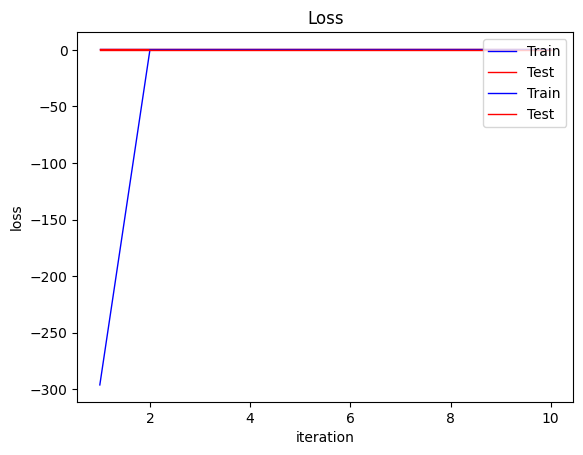

In [40]:
# Treinando Modelo ListNet
Model_ListWise = ListNet()
map_ListWise = Model_ListWise.fit(review[["userId", "itemId"]].to_numpy(), review["rating"].to_numpy(), n_epoch=10)

In [41]:
map_ListNet = pd.Series([
    map_ListWise[0],
    map_ListWise[2],
    map_ListWise[4],
    map_ListWise[9]
    ])

map_ListNet

0    0.825764
1    0.825764
2    0.825764
3    0.825764
dtype: float64

# Resultados

In [42]:
multicol1 = pd.MultiIndex.from_tuples([('Pointwise', 'SVD Otimizado'),
                ('Pointwise', 'IAKNN CaseRecommender'),
                ('Pointwise', 'IAKNN Cossine Similarity'),
                ("Pairwise", "BPRMF 5 Fatores"),
                ("Pairwise", "BPRMF 15 Fatores"),
                ("Pairwise", "BPRMF 30 Fatores"),
                ("Listwise", "ListNet")
            ])

# Adicionando MAPs de cada algoritmo
MAPs = np.array([map_svd, map_IAKNN, map_IAKNN_sim, map_BPRMF_5, map_BPRMF_15, map_BPRMF_30, map_ListNet]).T

# Unindo métricas de avaliação
metrics = pd.DataFrame(MAPs,
    columns=multicol1,
    index = ["MAP@1", "MAP@3", "MAP@5", "MAP@10"]
)

metrics


Pointwise                                                 \
       SVD Otimizado IAKNN CaseRecommender IAKNN Cossine Similarity   
MAP@1       0.065371              0.029418                 0.019842   
MAP@3       0.062340              0.029394                 0.019842   
MAP@5       0.062200              0.029394                 0.019842   
MAP@10      0.062188              0.029394                 0.019842   

              Pairwise                                    Listwise  
       BPRMF 5 Fatores BPRMF 15 Fatores BPRMF 30 Fatores   ListNet  
MAP@1         0.168172         0.166845         0.168071  0.825764  
MAP@3         0.163876         0.163621         0.164852  0.825764  
MAP@5         0.163872         0.163588         0.164856  0.825764  
MAP@10        0.163868         0.163588         0.164856  0.825764

In [43]:
# Recuperando similaridades por cosseno já calculadas
similarity_games = pd.read_csv("sim_games.dat", header=None, sep="\t")
similarity_games.columns = ["Game 1", "Game 2", "Similarity"]

In [44]:
# Recuperando similaridades por cosseno já calculadas
similarity_games = pd.read_csv("sim_games.dat", header=None, sep="\t")
similarity_games.columns = ["Game 1", "Game 2", "Similarity"]

# Calculando ILS para cada Algoritmo Pointwise
ILS_SVD = mean_ILS(result_svd, similarity_games)
ILS_IAKNN = mean_ILS(result_IAKNN, similarity_games)
ILS_IAKNN_Sim = mean_ILS(result_IAKNN_sim, similarity_games)

# Calculando ILS para cada Algoritmo Pairwise
ILS_BPRF_5 = mean_ILS(result_BPRMF_5, similarity_games)
ILS_BPRF_15 = mean_ILS(result_BPRMF_15, similarity_games)
ILS_BPRF_30 = mean_ILS(result_BPRMF_30, similarity_games)

In [47]:
# Adicionando Métrica ILS de cada Algoritmo
ILS_row = {
    ('Pointwise', 'SVD Otimizado'): ILS_SVD,
    ('Pointwise', 'IAKNN CaseRecommender'): ILS_IAKNN,
    ('Pointwise', 'IAKNN Cossine Similarity'): ILS_IAKNN_Sim,
    ("Pairwise", "BPRMF 5 Fatores"): ILS_BPRF_5,
    ("Pairwise", "BPRMF 15 Fatores"): ILS_BPRF_15,
    ("Pairwise", "BPRMF 30 Fatores"): ILS_BPRF_30,
    ("Listwise", "ListNet"): "Não se aplica"
}

metrics.loc["ILS", :] = ILS_row

In [48]:
# Exibindo métricas finais encontradas
metrics

Pointwise                                                 \
       SVD Otimizado IAKNN CaseRecommender IAKNN Cossine Similarity   
MAP@1       0.065371              0.029418                 0.019842   
MAP@3       0.062340              0.029394                 0.019842   
MAP@5       0.062200              0.029394                 0.019842   
MAP@10      0.062188              0.029394                 0.019842   
ILS        10.705737             17.714538                15.260545   

              Pairwise                                         Listwise  
       BPRMF 5 Fatores BPRMF 15 Fatores BPRMF 30 Fatores        ListNet  
MAP@1         0.168172         0.166845         0.168071       0.825764  
MAP@3         0.163876         0.163621         0.164852       0.825764  
MAP@5         0.163872         0.163588         0.164856       0.825764  
MAP@10        0.163868         0.163588         0.164856       0.825764  
ILS           8.090326         8.048933         7.898754  Não se aplica